<img src="https://images.unsplash.com/photo-1636019409964-5c88f004e330?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" width=400%>


<div class = 'alert alert-block alert-info'
     style = 'background-color:#e5e5de;
              color:#bd5aa8;
              border-width:5px;
              border-color:#bd5aa8;
              font-family:Comic Sans MS'>
    <p style = 'font-size:24px'>Exp001</p>
    <a href = "#Config"
       style = "color:#bd5aa8;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#bd5aa8;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#bd5aa8;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Preprocess"
       style = "color:#bd5aa8;
                font-size:14px">4.Preprocess</a><br>
    <a href = "#Training"
       style = "color:#bd5aa8;
                font-size:14px">5.Training</a><br>
</div>

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install japanize_matplotlib -q
!pip install wandb -q
!pip install nlplot -q
!pip install pytorch_lightning -U
!pip install transformers -Uq
!pip uninstall plotly -y
!pip install plotly -Uq
!pip install texthero==1.0.1 -q
!pip install python-box -U
!pip install rich -U

Found existing installation: plotly 5.4.0
Uninstalling plotly-5.4.0:
  Successfully uninstalled plotly-5.4.0


In [ ]:
!pip show pytorch_lightning

Name: pytorch-lightning
Version: 1.5.5
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/PyTorchLightning/pytorch-lightning
Author: William Falcon et al.
Author-email: waf2107@columbia.edu
License: Apache-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, future, torch, PyYAML, tqdm, tensorboard, pyDeprecate, torchmetrics, typing-extensions, packaging, fsspec
Required-by: 


## Libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import texthero as hero

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

In [ ]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 128,
    "environment": "Colab",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "001_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 64,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 32,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "roberta-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-4,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
pprint(config)

{'backbone': <Box: {'name': 'roberta-base', 'output_dim': 1}>,
 'entity': 'dataskywalker',
 'environment': 'Colab',
 'epoch': 5,
 'exp_name': '001_exp',
 'loss': 'nn.MarginRankingLoss',
 'margin': 0.5,
 'max_length': 128,
 'n_fold': 5,
 'optimizer': <Box: {'name': 'torch.optim.AdamW', 'params': {'lr': 0.0001}}>,
 'project': 'Jigsaw',
 'root': '/content/drive/MyDrive/kaggle/Jigsaw/raw',
 'scheduler': {'name': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': <Box: {'T_0': 20, 'eta_min': 0}>},
 'seed': 42,
 'test_loader': {'batch_size': 32,
                 'drop_last': False,
                 'num_workers': 1,
                 'pin_memory': True,
                 'shuffle': False},
 'tokenizer': PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>

In [ ]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'Colab'.
INPUT_DIR is /content/drive/MyDrive/kaggle/Jigsaw/raw
MODEL_DIR is /content/drive/MyDrive/kaggle/Jigsaw/interim/001_exp
OUTPUT_DIR is /content/drive/MyDrive/kaggle/Jigsaw/interim/001_exp


In [ ]:
# Seed固定
seed_everything(config.seed)

Global seed set to 42


42

In [ ]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

# Data Load

In [ ]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/content/drive/MyDrive/kaggle/Jigsaw/raw/comments_to_score.csv
/content/drive/MyDrive/kaggle/Jigsaw/raw/validation_data.csv
/content/drive/MyDrive/kaggle/Jigsaw/raw/sample_submission.csv


In [ ]:
df = pd.read_csv(INPUT_DIR/"validation_data.csv")
df.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


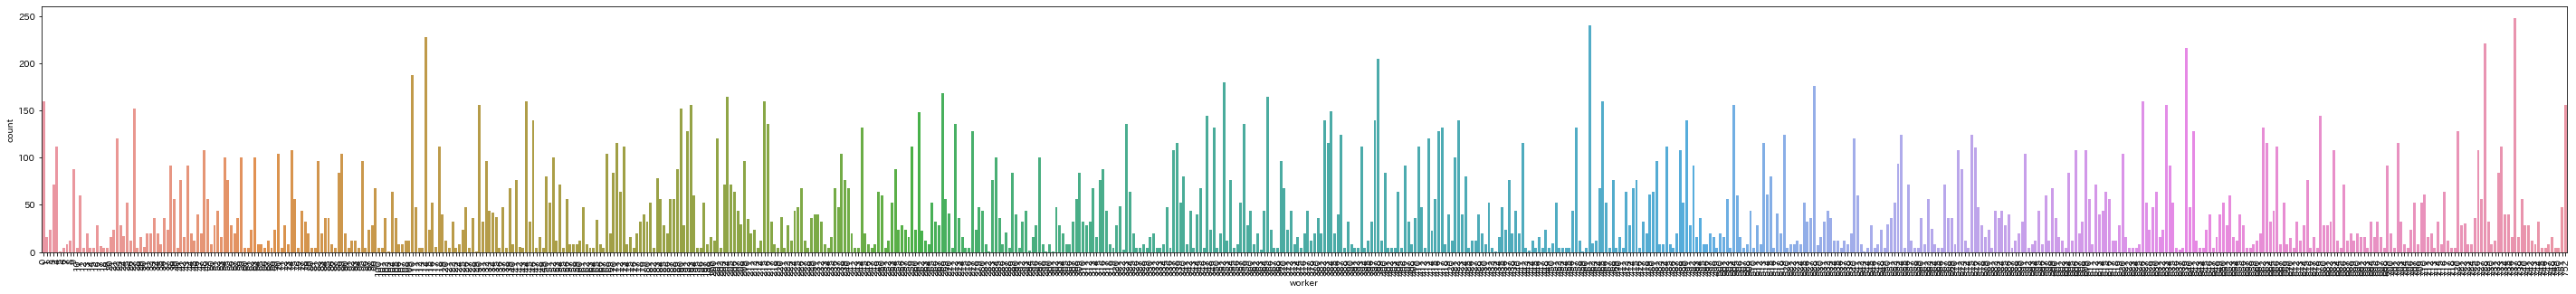

In [ ]:
plt.figure(figsize=(50, 5))
sns.countplot(x="worker", data=df)
plt.xticks(rotation=90)
plt.show()

## Create Folds

In [ ]:
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["worker"])):
    df.loc[val_idx, "kfold"] = int(fold)

df["kfold"] = df["kfold"].astype(int)
df.head()

,worker,less_toxic,more_toxic,kfold
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,3
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",4
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,4
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1


## Create Test Data

In [ ]:
test_df = pd.DataFrame()

for fold in range(config.n_fold):

    less_text = df[df["kfold"]==fold]["less_toxic"].values
    more_text = df[df["kfold"]==fold]["more_toxic"].values
    _test_df = pd.DataFrame()
    _test_df["text"] = np.concatenate((less_text, more_text), axis=0)
    _test_df["target"] = [0 for i in range(len(less_text))] + [1 for i in range(len(more_text))]
    _test_df["kfold"] = fold
    test_df = pd.concat([test_df, _test_df], axis=0).reset_index(drop=True)


display(test_df.head())

,text,target,kfold
0,"""And yes, people should recognize that but the...",0,0
1,"""\n\nHey Dude\nWell, I guess you know that TRE...",0,0
2,"""\n\n Sorry, I cant AFD the article while it i...",0,0
3,(1) It is a pity that you term well-sourced an...,0,0
4,"""\n\nIt is not false! I've showed you every po...",0,0


# Pytorch Dataset

In [ ]:
class JigsawDataset:

    def __init__(self, df, tokenizer, max_length, is_train):

        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.is_train = is_train
        if self.is_train:    
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values

        else:
            self.text = df["text"].values
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if self.is_train:
                
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                add_special_tokens=True,
                max_length = self.max_len,
                padding="max_length"
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )

            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]

            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.long)
            }

        else:
            text = self.text[index]
            inputs = self.tokenizer.encode_plus(
                text,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding="max_length"
            )

            ids = inputs["input_ids"]
            mask = inputs["attention_mask"]

            return {
                "ids": torch.tensor(ids, dtype=torch.long),
                "mask": torch.tensor(mask, dtype=torch.long)
            }

## DataModule

In [ ]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=False
        )

        return DataLoader(dataset, **self._cfg.test_loader)

## Data Check

In [ ]:
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(df, df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

Global seed set to 42


In [ ]:
data["more_toxic_ids"].size()
data["more_toxic_mask"].size()
data["less_toxic_ids"].size()
data["less_toxic_mask"].size()

torch.Size([32, 128])

In [ ]:
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(df, df, test_df, config).test_dataloader()
for data in sample_dataloader:
    break

Global seed set to 42


In [ ]:
data["ids"].size()
data["mask"].size()

torch.Size([32, 128])

## Model

In [ ]:
class JigsawModel(nn.Module):

    def __init__(self, model_name):

        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.2)
        self.head = nn.Linear(768, 1)

    def forward(self, ids, mask):

        out = self.model(input_ids=ids, attention_mask=mask, output_hidden_states=False)
        # out = self.norm(out)
        out = self.drop(out[1])
        outputs = self.head(out)

        return outputs

    def save(self, optim, epoch):
        self.eval()
        torch.save({
            "epoch": epoch,
            "model_state_dict": self.state_dict(),
            "optimizer_state_dict": optime.state_dict(),
            "loss":0,
        }, f"./{CONFIG.exp_name}_{epoch}.bin")

    def load(self, optim, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint["model_state_dict"])
        optim.load_state_dict(checkpoint["optimizer_state_dict"])
        self.epoch = checkpoint["epoch"]
        self.loss = checkpoint["loss"]

## Loss Function

In [ ]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=config.margin)(outputs1, outputs2, targets)

## Lightning Module

In [ ]:
class JigsawModel(pl.LightningModule):

    def __init__(self, cfg, fold_num):

        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = criterion
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num

    def __build_model(self):

        self.base_model = AutoModel.from_pretrained(self.cfg.backbone.name)
        print(f"Use Model: {self.cfg.backbone.name}")

        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)

    def forward(self, ids, mask):

        out = self.base_model(input_ids=ids, attention_mask=mask, output_hidden_states=False)
        out = self.norm(out[1])
        out = self.drop(out)
        outputs = self.head(out)

        return outputs

    def training_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        targets = batch['target']

        more_toxic_outputs = self.forward(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = self.forward(less_toxic_ids, less_toxic_mask)

        loss = self.criterion(more_toxic_outputs, less_toxic_outputs, targets)

        return {"loss":loss, "targets":targets}

    def training_epoch_end(self, training_step_outputs):

        loss_list = []
        target_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        targets = batch['target']

        more_toxic_outputs = self.forward(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = self.forward(less_toxic_ids, less_toxic_mask)

        loss = self.criterion(more_toxic_outputs, less_toxic_outputs, targets)

        return {"loss":loss, "targets":targets}

    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"valid_loss/fold{self.fold_num+1}":meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def test_step(self, batch, batch_idx):

        text_ids = batch['ids']
        text_mask = batch['mask']

        pred = self.forward(text_ids, text_mask)
        return {"pred":pred,}

    def test_epoch_end(self, test_step_outputs):

        pred_list = []

        for out in test_step_outputs:
            pred_list.extend([out["pred"].cpu().detach().numpy()])

        logs = {f"pred":pred_list,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False
        )

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int= None):

        text_ids = batch['ids']
        text_mask = batch['mask']
        pred = self.forward(text_ids, text_mask)
        return self(pred)

    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

In [ ]:
for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    df_test = test_df[test_df["kfold"]==fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, df_test, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "MarginLoss"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
        deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Linear       │    769 │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 847/847 0:05:28 • 0:00:00 3.58it/s loss: 0.298 v_num: rvi3 
                                                                     valid_loss/fold1: 0.354 
                                                                     train_loss/fold1: 0.037 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Linear       │    769 │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 847/847 0:05:27 • 0:00:00 3.58it/s loss: 0.297 v_num: rvi3 
                                                                     valid_loss/fold2: 0.339 
                                                                     train_loss/fold2: 0.038 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Linear       │    769 │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 847/847 0:05:28 • 0:00:00 3.57it/s loss: 0.285 v_num: rvi3 
                                                                     valid_loss/fold3: 0.343 
                                                                     train_loss/fold3: 0.039 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Linear       │    769 │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 847/847 0:05:28 • 0:00:00 3.57it/s loss: 0.305 v_num: rvi3 
                                                                     valid_loss/fold4: 0.342 
                                                                     train_loss/fold4: 0.038 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Linear       │    769 │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 847/847 0:05:28 • 0:00:00 3.57it/s loss: 0.311 v_num: rvi3 
                                                                     valid_loss/fold5: 0.37  
                                                                     train_loss/fold5: 0.037 

# Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRED = np.zeros(len(test_df))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_idx = test_df[test_df["kfold"]==fold].index.tolist()

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    df_test = test_df[test_df["kfold"]==fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, df_test, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).train_dataloader()
    test_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).test_dataloader()

    
    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_loss_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        ids = data["ids"].to(device)
        mask = data["mask"].to(device)
        preds = model(ids, mask)
        pred_list.append(preds[:, 0].detach().cpu().numpy())

    pred_list = np.concatenate(pred_list)
    PRED[test_idx] += pred_list

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/377 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/377 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/377 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/377 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/377 [00:00<?, ?it/s]

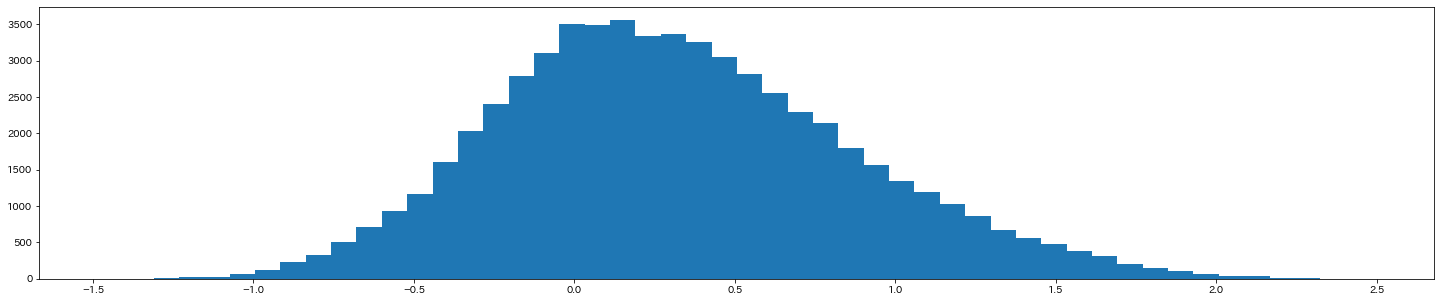

In [ ]:
plt.figure(figsize=(25, 5))
plt.hist(PRED, bins=50)
plt.show()

In [ ]:
test_df["score"] = PRED
test_df.head()

,text,target,kfold,score
0,"""And yes, people should recognize that but the...",0,0,-0.136785
1,"""\n\nHey Dude\nWell, I guess you know that TRE...",0,0,0.157425
2,"""\n\n Sorry, I cant AFD the article while it i...",0,0,0.328161
3,(1) It is a pity that you term well-sourced an...,0,0,0.306675
4,"""\n\nIt is not false! I've showed you every po...",0,0,1.053648


In [ ]:
test_df['rank_score'] = test_df['score'].rank(method='first')
test_df

,text,target,kfold,score,rank_score
0,"""And yes, people should recognize that but the...",0,0,-0.136785,12553.0
1,"""\n\nHey Dude\nWell, I guess you know that TRE...",0,0,0.157425,25097.0
2,"""\n\n Sorry, I cant AFD the article while it i...",0,0,0.328161,32455.0
3,(1) It is a pity that you term well-sourced an...,0,0,0.306675,31555.0
4,"""\n\nIt is not false! I've showed you every po...",0,0,1.053648,53997.0
...,...,...,...,...,...
60211,MY PAGE 3234434aAa \n\nYour just a mean OLD B...,1,4,0.750660,47448.0
60212,"""\n\n Possible Troll \n\nWhy is the word """"MON...",1,4,-0.127145,12910.0
60213,Bloody bots get more annoying every day.... He...,1,4,0.145908,24585.0
60214,get out my large penis,1,4,0.350063,33381.0


In [ ]:
test_df.groupby("target")[["score", "rank_score"]].agg("mean")

,score,rank_score
target,,
0,0.165645,25411.914408
1,0.469514,34805.085592
